# Исследование объявлений о продаже квартир

В распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Научимся определять рыночную стоимость объектов недвижимости. Задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Данные и общая информация. 

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import datetime
import calendar
import matplotlib.pyplot as plt 

In [2]:
df = pd.read_csv('/datasets/real_estate_data.csv', sep ='\t')

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


### Общая информация о данных

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

### Пропуски типа Nan в столбцах в процентах

<div class="alert alert-block alert-info" style="border-radius: 15px">
доля пропусков типа NaN
</div>

In [6]:
df_NaN_part = pd.DataFrame(data = df.isna().sum(), columns = ['NaN'])
df_NaN_part['NaN_%'] = round(df.isna().sum() / len(df) * 100, 2)
df_NaN_part = df_NaN_part.query('NaN != 0')
df_NaN_part

,NaN,NaN_%
ceiling_height,9195,38.80
floors_total,86,0.36
living_area,1903,8.03
is_apartment,20924,88.29
kitchen_area,2278,9.61
balcony,11519,48.61
locality_name,49,0.21
airports_nearest,5542,23.38
cityCenters_nearest,5519,23.29
parks_around3000,5518,23.28


### Вывод

данные содержат:

1.	23699 записей 


2.	22 столбца (параметра квартиры), 

    столбец **cityCenters_nearest** нужно перевести в нижний регистр
    

3.	данные содержат целые и вещественные числа, данные типа строка, возможно в верхем и нижнем регистре, логические данные


4.	пропуски типа Nan в столбцах - количество и доля в %:


    ceiling_height	9195	38.80
    
    floors_total	86	0.36
    
    living_area	1903	8.03
    
    is_apartment	20924	88.29
    
    kitchen_area	2278	9.61
    
    balcony	11519	48.61
    
    locality_name	49	0.21
    
    airports_nearest	5542	23.38
    
    cityCenters_nearest	5519	23.29
    
    parks_around3000	5518	23.28
    
    parks_nearest	15620	65.91
    
    ponds_around3000	5518	23.28
    
    ponds_nearest	14589	61.56
    
    days_exposition	3181	13.42

5.	категориальные и количественные данные


6.	возможны дубликаты: полные и частичные

## Предобработка данных

Для заполнения пропусков **living_area**, **kitchen_area** применим нормирование

вычислим коэффициенты там где имеем полные данные

медиана отношения **living_area** к **total_area**

медиана отношения **kitchen_area** к **total_area**

заполним пропуски произведением на соответствующую медиану

In [7]:
df.living_area = df.living_area.fillna((df.living_area / df.total_area).median() * df.total_area).astype(int) 

In [8]:
df.kitchen_area = df.kitchen_area.fillna((df.kitchen_area / df.total_area).median() * df.total_area).astype(int) 

в столбце **balcony** заменяем 11519 пропуcов NaN на значение количества балконов - 0, вероятней всего, наличие балкона не указали по причине его отсутствия

In [9]:
df.balcony = df.balcony.fillna(0) 

в столбце **is_apartment** заменяем 20924 пропуcов NaN на значение False, т.е. - жилое помещение

In [10]:
df.query('is_apartment == True')['is_apartment'].sum() / len(df) * 100

0.21097936621798388

In [11]:
df.is_apartment = df.is_apartment.fillna(value='False')

пропуски столбца **ceiling_height** заменяем на медианы

In [12]:
df.ceiling_height = df.ceiling_height.fillna(df.ceiling_height.median())

изменим тип данных строка столбца **first_day_exposition** на объект datetime

In [13]:
df.first_day_exposition = pd.to_datetime(df.first_day_exposition, format='%Y-%m-%dT%H:%M:%S')

столбец **cityCenters_nearest** переводим в нижний регистр

In [14]:
df = df.rename(columns={'cityCenters_nearest': 'city_centers_nearest'})

изменим вещественный тип данных столбца **last_price**, **balcony** на целочисленный для лучшего восприятия

In [15]:
df[['last_price', 'balcony']] = df[['last_price', 'balcony']].astype(int) 

### Дополнительные признаки

добавим столбец: цена квадратного метра **price_meter**

отношение **last_price** к **total_area**

In [16]:
df['price_meter'] = (df.last_price / df.total_area).astype(int)

добавим столбцы: день недели, месяц и год публикации объявления

In [17]:
df['weekday_exposition'] = df.first_day_exposition.dt.weekday

In [18]:
def weekday_func(weekday):
    if weekday == 0:
        return 'понедельник' 
    if weekday == 1:
        return 'вторник'
    if weekday == 2:
        return 'среда'
    if weekday == 3:
        return 'четверг'
    if weekday == 4:
        return 'пятница'
    if weekday == 5:
        return 'суббота'
    if weekday == 6:
        return 'воскресенье'

df['weekday_exposition_name'] = df.weekday_exposition.apply(weekday_func) 

In [19]:
df['year_exposition'] = df.first_day_exposition.dt.year

In [20]:
df['month_exposition'] = df.first_day_exposition.dt.month

добавим столбцы: этаж квартиры; варианты — первый, последний, другой

In [36]:
def floor_func(df):
    if df.floor == 1:
        return 'первый' 
    if df.floor == df.floors_total:
        return 'последний'
    return 'другой'  

In [37]:
df['floor_rank'] = df.apply(floor_func, axis=1)

Выборка демонстрирует "ассортимент" этажей

In [38]:
df.loc[10:15, ['floor', 'floors_total', 'floor_rank']]

,floor,floors_total,floor_rank
10,3,12.0,другой
11,4,5.0,другой
12,5,5.0,последний
13,5,5.0,последний
14,1,6.0,первый
15,5,14.0,другой


добавим столбцы: соотношение жилой и общей площади, а также отношение площади кухни к общей.

In [39]:
df['living_total_area'] = round(df.living_area / df.total_area, 1)

In [40]:
df['kitchen_total_area'] = round(df.kitchen_area / df.total_area, 1)

### Шаг 5. Проведите исследовательский анализ данных и выполните инструкции:

#### Анализ столбца **last_price** с учетом **price_meter**

In [41]:
df.last_price.describe().astype(int)

count        23699
mean       6541548
std       10887013
min          12190
25%        3400000
50%        4650000
75%        6800000
max      763000000
Name: last_price, dtype: int64

<AxesSubplot:>

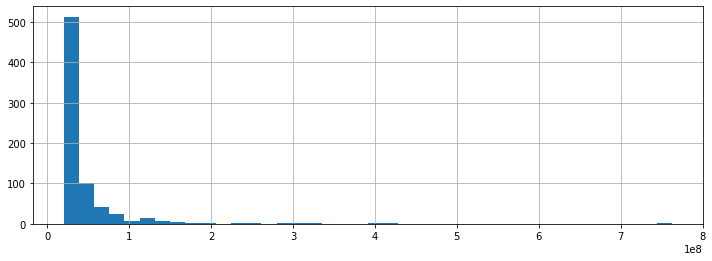

In [42]:
df.last_price.hist(bins = 40, range = (20000000, 763000000), figsize = (12, 4))

(0.0, 13000000.0)

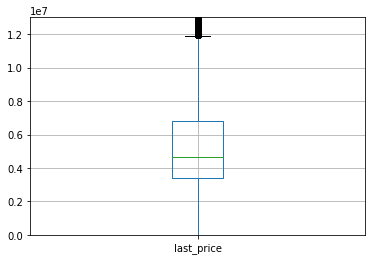

In [43]:
df.boxplot('last_price') 
plt.ylim(0, 13000000)

<div class="alert alert-block alert-info" style="border-radius: 15px">
указанная стоимость квартиры 12190 - таких цен не бывает, это ошибка, удаляем
</div>

In [44]:
df = df.query('last_price > 400000')

<div class="alert alert-block alert-info" style="border-radius: 15px">
Нижний ус составляет - 470 тыс., верхний - 10.750 млн. много значений за пределами усов
</div>

In [448]:
round(df.query('last_price > 200000000 & price_meter > 100000').pivot_table(index = 'last_price', values = [
    'price_meter', 'total_area', 'rooms', 'ceiling_height', 'locality_name', 
    'days_exposition']))

,ceiling_height,days_exposition,price_meter,rooms,total_area
last_price,,,,,
230000000,3.0,50.0,460000,6,500.0
240000000,3.0,199.0,585365,6,410.0
245000000,3.0,249.0,857542,6,286.0
289238400,3.0,NaN,1542604,2,188.0
300000000,3.0,111.0,485436,7,618.0
330000000,4.0,233.0,1736842,3,190.0
401300000,3.0,393.0,1000748,5,401.0
420000000,3.0,106.0,466666,12,900.0
763000000,3.0,33.0,1907500,7,400.0


<div class="alert alert-block alert-info" style="border-radius: 15px">

**2** 
    
Удаляем выбросы, которые искажают картину и смещают распределение вправо:
    
Аномально дорогие квартиры с ценой кв. метра более 1 млн.
    
Жилье площадью 900 кв. м и 12 комнатами
    
</div>


In [449]:
df = df.query('price_meter < 1000000 & total_area < 900 & rooms < 10')

<div class="alert alert-block alert-info" style="border-radius: 15px">

**3** 
    
Эту квартиру я упустил.
    
В df ТОР 5 квартира не выглядит выбросом, но boxplot это наглядно демонстрирует
    
Для того, чтобы эту точку оставить не хватает небольшой группы - такая группа заканчивается на значении 245000000 Точка выглядит как выброс, который может исказить "вправо" общую картину - удаляем выброс
    
</div>

(100000000, 400000000)

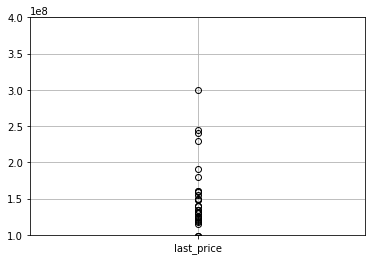

In [451]:
df.boxplot('last_price') 
plt.ylim(100000000, 400000000)

In [452]:
df.sort_values(by = 'last_price', ascending = False).head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_meter,weekday_exposition,weekday_exposition_name,year_exposition,month_exposition,floor_rank,living_total_area,kitchen_total_area
15651,20,300000000,618.0,2017-12-18,7,3.40,7.0,258,5,False,False,False,70,0,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,111.0,485436,0,понедельник,2017,12,другой,0.4,0.1
16461,17,245000000,285.7,2017-04-10,6,3.35,7.0,182,4,False,False,False,29,0,Санкт-Петербург,33143.0,6235.0,3.0,400.0,3.0,140.0,249.0,857542,0,понедельник,2017,4,другой,0.6,0.1
13749,7,240000000,410.0,2017-04-01,6,3.40,7.0,218,7,False,False,False,40,0,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,199.0,585365,5,суббота,2017,4,последний,0.5,0.1
5893,3,230000000,500.0,2017-05-31,6,2.65,7.0,283,7,False,False,False,40,0,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,50.0,460000,2,среда,2017,5,последний,0.6,0.1
8900,13,190870000,268.0,2016-03-25,3,2.65,8.0,132,7,False,False,False,40,0,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,901.0,712201,4,пятница,2016,3,другой,0.5,0.1


In [453]:
df = df.query('last_price < 250000000')

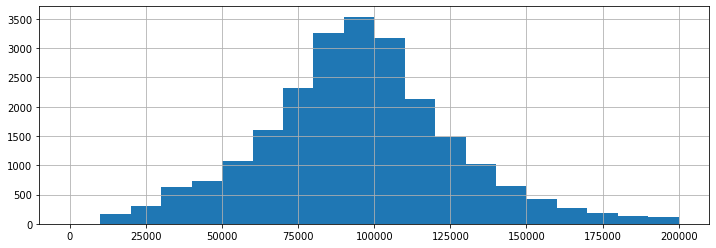

In [454]:
df.price_meter.hist(bins = 20, range = (0,200000), figsize = (12, 4))

(15000, 200000)

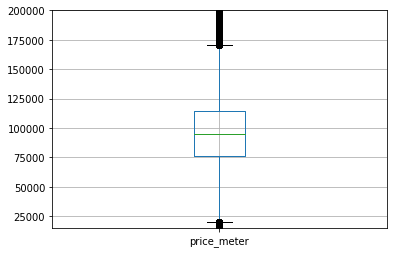

In [455]:
df.boxplot('price_meter') 
plt.ylim(15000, 200000)

<div class="alert alert-block alert-info" style="border-radius: 15px">
Нижний ус составляет - 20140, верхний - 170650, много значений за пределами усов
</div>

<div class="alert alert-block alert-info" style="border-radius: 15px">
Наибольшее число квартир имеют цены в диапазоне от 3 до 6 млн

это объясняется бОльшим количеством стандартных "средних" вариантов и более высоким спросом на них
    
Типичные цены на квартиры - это цены с распространенным значением при условии распространенной цены за кв. метр.
</div>

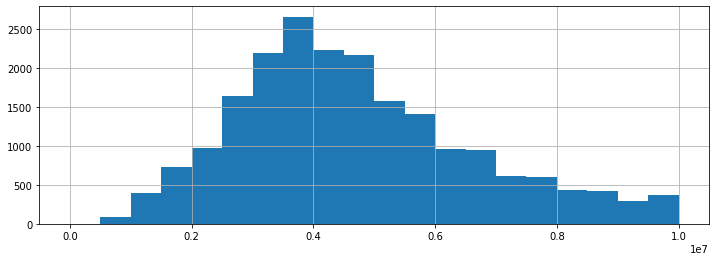

In [456]:
df.query('20100 < price_meter < 170730').last_price.hist(bins = 20, range = (0,10000000), figsize = (12, 4))

#### Анализ столбца **total_area**

In [457]:
df.total_area.describe().astype(int)

count    23682
mean        60
std         34
min         12
25%         40
50%         52
75%         69
max        631
Name: total_area, dtype: int64

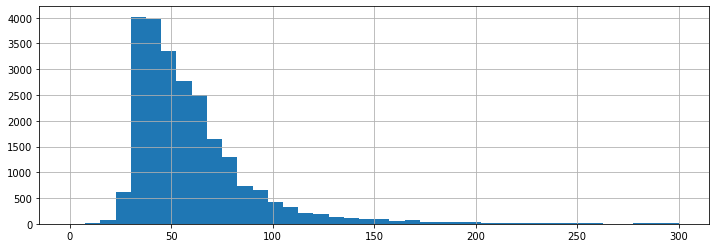

In [458]:
df['total_area'].hist(bins = 40, range = (0, 300), figsize = (12, 4))

(0, 150)

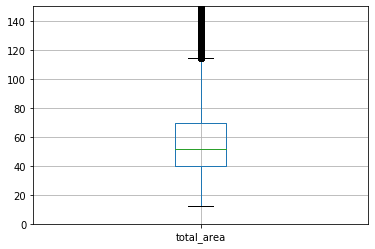

In [459]:
df.boxplot('total_area') 
plt.ylim(0, 150)

<div class="alert alert-block alert-info" style="border-radius: 15px">
Нижний ус составляет - 12 кв.м., верхний - 114 кв.м., много значений за пределами усов
</div>

Количество квартир с площадью от 30 до 50 кв.м. более востребованы из-за доступной цены и высокой ликвидности

<div class="alert alert-block alert-info" style="border-radius: 15px">
    
**2** 
    
Удаляем выбросы, которые искажают картину и смещают распределение влево жилье площадью меньше 15 кв. м. 
</div>

In [460]:
df.query('total_area < 15')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_meter,weekday_exposition,weekday_exposition_name,year_exposition,month_exposition,floor_rank,living_total_area,kitchen_total_area
17961,3,1400000,13.0,2017-12-03,1,2.60,9.0,7,1,False,False,False,2,0,Санкт-Петербург,14350.0,15945.0,0.0,NaN,1.0,185.0,410.0,107692,6,воскресенье,2017,12,первый,0.5,0.2
19546,3,1850000,13.0,2019-03-11,1,3.40,5.0,7,2,False,False,False,2,0,Санкт-Петербург,24915.0,5483.0,1.0,644.0,0.0,NaN,24.0,142307,0,понедельник,2019,3,другой,0.5,0.2
19558,2,1686000,13.2,2018-12-17,1,2.65,5.0,7,1,False,False,False,2,0,Санкт-Петербург,19891.0,4165.0,1.0,361.0,1.0,155.0,19.0,127727,0,понедельник,2018,12,первый,0.5,0.2
19642,5,1190000,14.0,2018-07-29,1,2.65,5.0,11,1,False,False,False,2,0,Санкт-Петербург,9898.0,11122.0,0.0,NaN,0.0,NaN,4.0,85000,6,воскресенье,2018,7,первый,0.8,0.1
19807,0,3800000,13.0,2018-07-04,1,2.65,5.0,10,3,False,False,False,2,0,Санкт-Петербург,21302.0,1242.0,1.0,592.0,3.0,27.0,9.0,292307,2,среда,2018,7,другой,0.8,0.2
19904,4,2400000,12.0,2017-07-19,1,2.55,5.0,10,2,False,False,False,2,0,Санкт-Петербург,21314.0,964.0,1.0,886.0,2.0,45.0,200.0,200000,2,среда,2017,7,другой,0.8,0.2


In [461]:
df = df.query('total_area > 15')

#### Анализ столбца **rooms**

In [462]:
df.rooms.value_counts()

1    8039
2    7938
3    5813
4    1180
5     325
0     197
6     105
7      57
8      12
9       8
Name: rooms, dtype: int64

Подтверждая предыдущие выводы, по нисходящей, популярны 1 - 2 - 3 комнатные квартиры

Прослеживается логика: изолированное жилье + доступная цена

#### Анализ столбца **ceiling_height**

In [463]:
round(df.ceiling_height.describe(), 2)

count    23674.00
mean         2.72
std          0.99
min          1.00
25%          2.60
50%          2.65
75%          2.70
max        100.00
Name: ceiling_height, dtype: float64

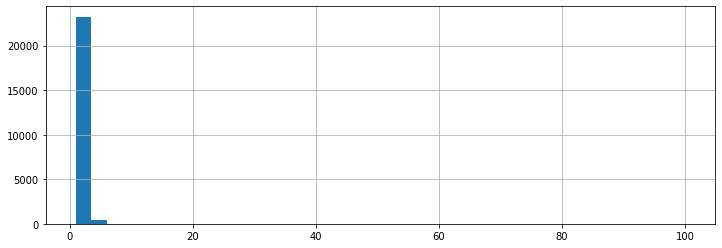

In [464]:
df.ceiling_height.hist(bins = 40, figsize = (12, 4))

(2.4, 3)

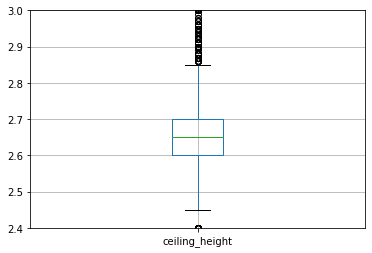

In [465]:
df.boxplot('ceiling_height') 
plt.ylim(2.4, 3)

по нормам высота потолка не может быть менее 2.5 метров 
Нижний ус составляет - 2.45 м., верхний - 2.85 м., все варианты за пределами усов - выбросы. Оставляем значения в пределах усов, как самые показательные для анализа c учетом того, что высокие потолки тоже могут быть. Отбросим варианты более 3.5 метров - менее 5%

<div class="alert alert-block alert-info" style="border-radius: 15px">
по нормам высота потолка не может быть менее 2.5 метров 
Нижний ус составляет - 2.5 м., верхний - 2.85 м., много значений за пределом верзнего уса - сохряняем, т.к. группа значений большая
    
варианты с потолками ниже 2.5 м. удаляем
</div>

In [466]:
df.query('ceiling_height > 2.85')['ceiling_height'].sum() / len(df) * 100

41.617470642899384

In [467]:
df = df.query('2.5 < ceiling_height')

Большинство квартир имеет высоту потолков от 2.5 до 2.8 метров, самый распространенный вариант - 2.65 м., реже встречается высота 3 метра.

In [468]:
df.query('rooms > 10')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_meter,weekday_exposition,weekday_exposition_name,year_exposition,month_exposition,floor_rank,living_total_area,kitchen_total_area


In [469]:
df.query('ceiling_height > 6').count(). count()

30

<div class="alert alert-block alert-info" style="border-radius: 15px">

**2** удаляем варианты с ненормалным количеством комнат и высотой потолков 
    
</div>

In [470]:
df = df.query('ceiling_height < 6 and rooms < 10')

#### Анализ времени продажи квартиры

In [471]:
df['days_exposition'].describe()

count    17522.000000
mean       183.591599
std        221.941751
min          2.000000
25%         45.000000
50%         97.000000
75%        236.000000
max       1572.000000
Name: days_exposition, dtype: float64

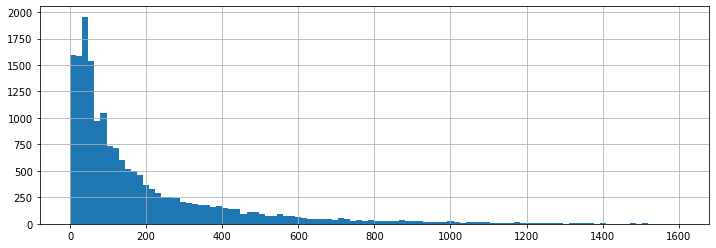

In [472]:
df.days_exposition.hist(bins = 100, range = (0, 1600), figsize = (12, 4))

(0, 600)

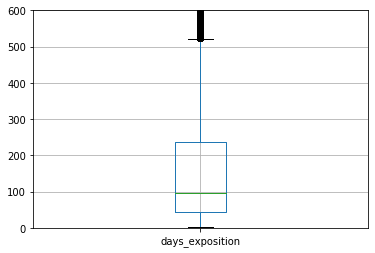

In [473]:
df.boxplot('days_exposition') 
plt.ylim(0, 600)

<div class="alert alert-block alert-info" style="border-radius: 15px">

**2** 
    
Нижний ус составляет - 1 день, верхний - 522 дней, все варианты за пределами усов - 1415 квартир, которые имеют отклонения от стандарта.

1й квартиль - 45 дней, 3й - 236

Например, очевидно, что средние и медианы цен за квартиру и за кв. метр выше у тех квартир, которые продавались дольше 
    
</div>

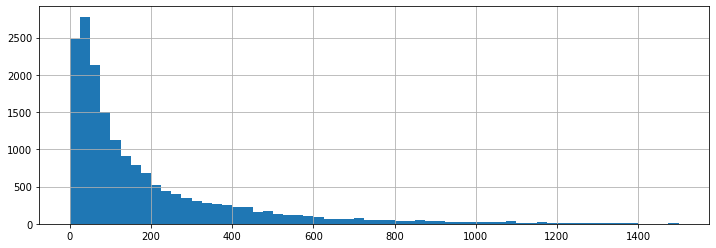

In [474]:
df.days_exposition.hist(bins = 60, range = (0, 1500), figsize = (12, 4))

Обычное время продажи квартир занимает до 3х месяцев, но четкой закономерности на данном этапе не видно, сроки могут быть увеличены до года и более - требуется учесть основные характеристики, влияющие на ликвидность.
Время продажи квартиры: средний показатель в 2 раза выше медианы, говорит о наличии вариантов со значительным (до 4х лет и более) сроком продажи. Есть 2 скачка по количеству проданных квартир 45 и 60 дней - вероятно связано с оформлением дополнительных докуметов в ряде случаев для купли-продажи (например, опека и т.д.)

In [475]:
round(df.query('days_exposition <= 10').describe(), 1)

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_meter,weekday_exposition,year_exposition,month_exposition,living_total_area,kitchen_total_area
count,1054.0,1054.0,1054.0,1054.0,1054.0,1052.0,1054.0,1054.0,1054.0,1054.0,843.0,844.0,844.0,342.0,844.0,388.0,1054.0,1054.0,1054.0,1054.0,1054.0,1054.0,1054.0
mean,9.6,5562333.2,53.9,1.8,2.7,11.8,30.1,6.2,9.8,0.7,28134.8,13927.0,0.6,489.0,0.7,541.3,6.4,100352.3,2.6,2017.8,6.8,0.6,0.2
std,6.2,5227758.2,30.3,0.9,0.2,6.7,19.3,4.9,5.6,1.0,12430.6,7450.8,0.8,339.8,0.9,287.8,2.2,38823.4,1.8,0.8,3.5,0.1,0.1
min,0.0,550000.0,16.0,0.0,2.5,1.0,9.0,1.0,2.0,0.0,7056.0,591.0,0.0,16.0,0.0,24.0,2.0,12724.0,0.0,2016.0,1.0,0.1,0.1
25%,5.0,3482500.0,37.4,1.0,2.6,5.0,18.0,3.0,7.0,0.0,16834.5,10359.2,0.0,303.8,0.0,318.8,4.0,80193.2,1.0,2017.0,4.0,0.5,0.1
50%,9.0,4461000.0,46.0,2.0,2.6,10.0,27.0,5.0,9.0,0.0,27164.0,13163.5,0.0,470.0,0.0,528.0,7.0,96640.0,3.0,2018.0,7.0,0.6,0.2
75%,14.0,6016262.2,62.6,2.0,2.7,16.0,37.0,8.0,11.0,1.0,36435.5,15866.0,1.0,597.0,1.0,761.2,8.0,114510.0,4.0,2018.0,10.0,0.6,0.2
max,50.0,59000000.0,494.1,8.0,5.3,35.0,280.0,33.0,85.0,5.0,68491.0,53028.0,3.0,3064.0,3.0,1299.0,10.0,462745.0,6.0,2019.0,12.0,1.0,0.6


In [476]:
round(df.query('days_exposition > 500').describe())

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_meter,weekday_exposition,year_exposition,month_exposition,living_total_area,kitchen_total_area
count,1535.0,1535.0,1535.0,1535.0,1535.0,1528.0,1535.0,1535.0,1535.0,1535.0,1250.0,1253.0,1253.0,632.0,1253.0,728.0,1535.0,1535.0,1535.0,1535.0,1535.0,1535.0,1535.0
mean,9.0,9068028.0,74.0,2.0,3.0,11.0,42.0,6.0,12.0,1.0,27536.0,12015.0,1.0,502.0,1.0,467.0,759.0,108776.0,3.0,2016.0,6.0,1.0,0.0
std,6.0,13393709.0,45.0,1.0,0.0,7.0,29.0,5.0,8.0,1.0,11075.0,9076.0,1.0,393.0,1.0,278.0,225.0,59803.0,2.0,1.0,4.0,0.0,0.0
min,0.0,500000.0,18.0,0.0,3.0,2.0,9.0,1.0,3.0,0.0,6949.0,318.0,0.0,11.0,0.0,19.0,501.0,12542.0,0.0,2014.0,1.0,0.0,0.0
25%,5.0,3900000.0,44.0,1.0,3.0,5.0,20.0,2.0,8.0,0.0,19876.0,5223.0,0.0,279.0,0.0,240.0,578.0,78974.0,1.0,2015.0,3.0,0.0,0.0
50%,8.0,5750000.0,62.0,2.0,3.0,9.0,35.0,4.0,10.0,0.0,24964.0,10905.0,1.0,441.0,1.0,437.0,698.0,97087.0,2.0,2016.0,6.0,1.0,0.0
75%,13.0,9500000.0,89.0,3.0,3.0,16.0,52.0,8.0,14.0,1.0,34973.0,15092.0,1.0,620.0,2.0,658.0,888.0,123594.0,4.0,2016.0,10.0,1.0,0.0
max,24.0,190870000.0,507.0,9.0,6.0,35.0,301.0,26.0,93.0,5.0,84869.0,65968.0,3.0,2467.0,3.0,1341.0,1572.0,719298.0,6.0,2017.0,12.0,1.0,1.0


<div class="alert alert-block alert-info" style="border-radius: 15px">
если в качестве примера сравнить информацию по квартирам, проданным в период до 10 дней и более 1.5 лет, то можно сказать:
    
"быстрое" жилье дешевле, но при этом кв. метр стоит примерно как и у "медленного", "медленное" жилье имеет большую площадь, отсюда более высокая цена и низкий спрос.
</div>

<div class="alert alert-block alert-info" style="border-radius: 15px">
    
**2** 
    
вероятно, что 
    
очень быстрая продажа проходит в период до 45 дней

в то время, как продажу более 230 дней следует отнести к очень длительной
    
boxplot представлен выше
    
</div>

#### Удаление редких и выбивающихся значений

<div class="alert alert-block alert-info" style="border-radius: 15px">
    
**2**
    
В ходе анализа распределения значений характеристик удалены выбросы:

1. стоимость 12190

2. площадь менее 15 кв.м и более 900 кв.м.

3. высота потолка до 2.5 м. и более 8 м.

4. цена кв. метра более 1 млн.

5. более 10 комнат
    
    
сбросим индекс
</div>

In [477]:
df.reset_index(inplace = True)

#### Влияние характеристик на цену

зависимость цены от площади, числа комнат, удалённости от центра, этажа, дня недели, месяца и года.

In [478]:
df[['last_price', 'total_area', 'rooms', 'city_centers_nearest', 
    'floor', 'weekday_exposition', 'month_exposition', 'year_exposition']].corr()

,last_price,total_area,rooms,city_centers_nearest,floor,weekday_exposition,month_exposition,year_exposition
last_price,1.000000,0.732246,0.437647,-0.259373,0.002296,-0.002955,-0.000628,-0.046347
total_area,0.732246,1.000000,0.768557,-0.237376,-0.054965,-0.008225,0.003171,-0.069881
rooms,0.437647,0.768557,1.000000,-0.205631,-0.167707,-0.008227,-0.003104,-0.056998
city_centers_nearest,-0.259373,-0.237376,-0.205631,1.000000,0.035311,0.014381,-0.007251,0.026230
floor,0.002296,-0.054965,-0.167707,0.035311,1.000000,0.012771,0.018844,0.018913
weekday_exposition,-0.002955,-0.008225,-0.008227,0.014381,0.012771,1.000000,0.021378,-0.002419
month_exposition,-0.000628,0.003171,-0.003104,-0.007251,0.018844,0.021378,1.000000,-0.258108
year_exposition,-0.046347,-0.069881,-0.056998,0.026230,0.018913,-0.002419,-0.258108,1.000000


цена квартиры в основном зависит от площади и от количества комнат но в меньшей степени.

присутствует слабая обратная связь  цены и расстояния до центра

практически не оказывают на стоимость влияние этаж и дата размещения

In [479]:
df_top_10 = pd.DataFrame(data = df.locality_name.value_counts().head(10))
df_top_10['price_meter_mean'] = df.groupby('locality_name')['price_meter'].mean()
df_top_10.price_meter_mean.sort_values(ascending = False).astype(int)

Санкт-Петербург      116556
Пушкин               104997
деревня Кудрово       92454
посёлок Парголово     90108
посёлок Мурино        85641
посёлок Шушары        78653
Колпино               75354
Всеволожск            69144
Гатчина               68988
Выборг                58573
Name: price_meter_mean, dtype: int64

<div class="alert alert-block alert-info" style="border-radius: 15px">
    
**2**
    
Из Топ - 10 населенных пунктов по количеству объявлений 
    
Санкт-Петербург имеет самую высокую среднюю стоимость кв. метра, а Выборг - самую низкую
    
</div>

In [480]:
df_sankt_peterburg = df.query('locality_name == "Санкт-Петербург"')

In [481]:
round(df_sankt_peterburg.describe())

,index,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_meter,weekday_exposition,year_exposition,month_exposition,living_total_area,kitchen_total_area
count,13545.0,13545.0,13545.0,13545.0,13545.0,13545.0,13475.0,13545.0,13545.0,13545.0,13545.0,13462.0,13485.0,13485.0,6333.0,13485.0,7113.0,11815.0,13545.0,13545.0,13545.0,13545.0,13545.0,13545.0
mean,11819.0,10.0,8362591.0,67.0,2.0,3.0,12.0,38.0,6.0,11.0,1.0,27704.0,11338.0,1.0,500.0,1.0,514.0,188.0,116557.0,3.0,2017.0,6.0,1.0,0.0
std,6817.0,6.0,10316428.0,41.0,1.0,0.0,7.0,26.0,5.0,7.0,1.0,11028.0,4970.0,1.0,358.0,1.0,280.0,229.0,49098.0,2.0,1.0,3.0,0.0,0.0
min,0.0,0.0,1350000.0,16.0,0.0,3.0,1.0,2.0,1.0,1.0,0.0,0.0,181.0,0.0,1.0,0.0,13.0,2.0,15345.0,0.0,2014.0,1.0,0.0,0.0
25%,5882.0,6.0,4350000.0,42.0,1.0,3.0,6.0,20.0,3.0,8.0,0.0,18867.0,7442.0,0.0,289.0,0.0,284.0,44.0,91904.0,1.0,2017.0,3.0,0.0,0.0
50%,11837.0,10.0,5850000.0,57.0,2.0,3.0,10.0,32.0,5.0,10.0,0.0,26346.0,12062.0,0.0,456.0,1.0,495.0,98.0,106212.0,3.0,2017.0,6.0,1.0,0.0
75%,17662.0,14.0,8700000.0,78.0,3.0,3.0,16.0,46.0,9.0,13.0,1.0,35908.0,14782.0,1.0,619.0,1.0,733.0,241.0,127098.0,4.0,2018.0,10.0,1.0,0.0
max,23697.0,50.0,245000000.0,631.0,9.0,6.0,52.0,358.0,33.0,107.0,5.0,54784.0,29493.0,3.0,3190.0,3.0,1337.0,1572.0,995983.0,6.0,2019.0,12.0,1.0,1.0


<div class="alert alert-block alert-info" style="border-radius: 15px">
    
**2**
    
city_centers_nearest. среднее 11338 и медиана 12062 очень близки по значению
    
для исключения ошибок заменим пропуски на среднее
    
</div>

In [482]:
import warnings
warnings.filterwarnings('ignore')

<div class="alert alert-block alert-info" style="border-radius: 15px">
    
**2**
    
выясняем, какая область входит в центр Санкт-Петербурга

1. создаем столбец с расстоянием до центра в километрах
2. получим среднюю цену для каждого километра
3. построение графика, где график сильно меняется — это и будет центральная зона.
    
</div>

In [483]:
df_sankt_peterburg.city_centers_nearest = df_sankt_peterburg.city_centers_nearest.fillna(df_sankt_peterburg.city_centers_nearest.mean())

In [484]:
df_sankt_peterburg['city_centers_nearest_km'] = df_sankt_peterburg['city_centers_nearest'] / 1000

In [485]:
df_sankt_peterburg['city_centers_nearest_km'] = round(df_sankt_peterburg['city_centers_nearest_km'], 1)

In [486]:
df_sankt_peterburg['mean_price_km'] = round(df_sankt_peterburg['last_price'] / df_sankt_peterburg['city_centers_nearest_km'])

In [487]:
df_sankt_peterburg_pivot = round(df_sankt_peterburg.pivot_table(index = 'city_centers_nearest_km', values = 'mean_price_km'))

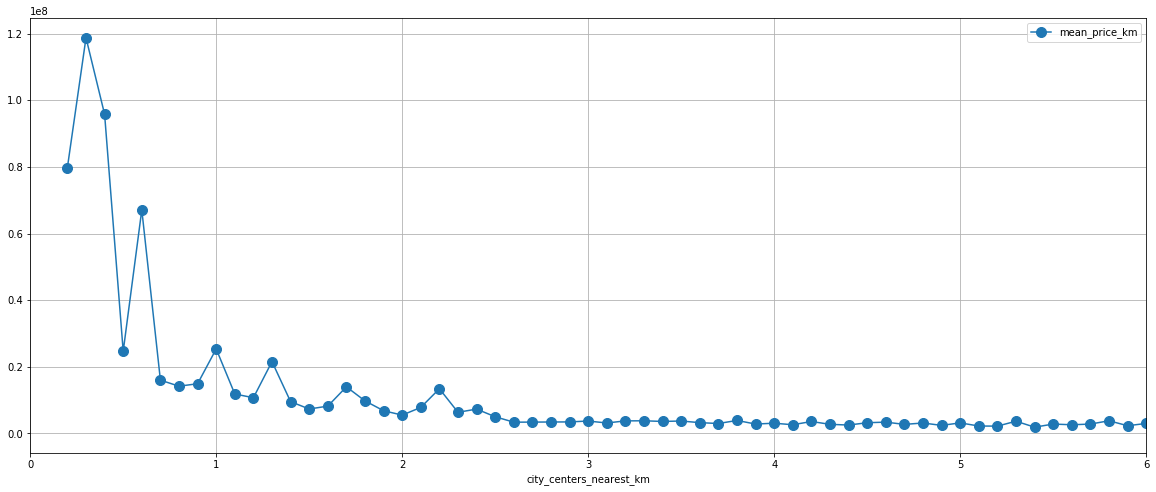

In [488]:
df_sankt_peterburg_pivot.plot(style="o-", xlim = (0, 6), figsize = (20,8), ms=10, grid = True)

In [489]:
df_sankt_peterburg_pivot = df_sankt_peterburg.pivot_table(index = 'city_centers_nearest_km', values = 'last_price')

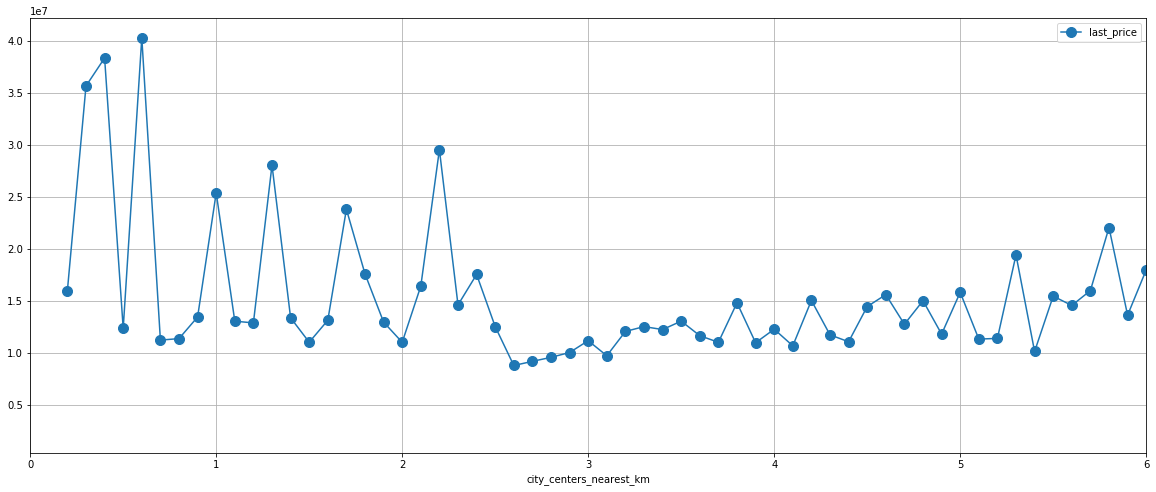

In [490]:
df_sankt_peterburg_pivot.plot(style="o-", xlim = (0, 6), figsize = (20,8), ms=10, grid = True)

<div class="alert alert-block alert-info" style="border-radius: 15px">
    
**3** 
    
**2 км. изменил на 2,5 км.**
    
**из 2х графиков видно:**
    
1. обратная кореляция стоимости жилья и расстояния от центра - с увеличением расстояния, цена жилья падает

2. центральную зону города можно ограничить радиусом **2,5 км.** - резкое изменение графика, нет скачков цен
    
</div>

In [491]:
df_sankt_peterburg_center = df_sankt_peterburg.query('city_centers_nearest_km < 2')

In [492]:
round(df_sankt_peterburg_center.describe(), 1)

,index,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_meter,weekday_exposition,year_exposition,month_exposition,living_total_area,kitchen_total_area,city_centers_nearest_km,mean_price_km
count,305.0,305.0,305.0,305.0,305.0,305.0,305.0,305.0,305.0,305.0,305.0,305.0,305.0,305.0,258.0,305.0,305.0,252.0,305.0,305.0,305.0,305.0,305.0,305.0,305.0,305.0
mean,11451.8,10.2,18618213.5,106.2,3.3,3.1,4.7,66.5,3.0,15.7,0.1,21689.6,1243.4,1.8,413.1,2.5,239.0,275.3,163594.5,2.6,2017.0,6.5,0.6,0.2,1.2,22475707.3
std,6910.3,6.3,22719011.2,64.4,1.4,0.5,1.0,44.7,1.4,11.5,0.4,1084.3,466.4,1.1,199.1,0.6,186.7,291.8,119515.0,1.7,1.2,3.6,0.1,0.1,0.5,41882292.7
min,155.0,0.0,3380000.0,27.0,0.0,2.6,2.0,15.0,1.0,5.0,0.0,17863.0,181.0,0.0,65.0,1.0,22.0,3.0,57961.0,0.0,2014.0,1.0,0.3,0.0,0.2,1778947.0
25%,5190.0,5.0,8250000.0,68.6,2.0,2.6,4.0,39.0,2.0,9.0,0.0,20921.0,911.0,1.0,282.2,2.0,78.0,68.8,102564.0,1.0,2016.0,3.0,0.6,0.1,0.9,5812500.0
50%,11748.0,10.0,11300000.0,88.4,3.0,3.0,5.0,54.0,3.0,12.0,0.0,21643.0,1280.0,2.0,394.0,3.0,202.0,160.5,126728.0,3.0,2017.0,7.0,0.6,0.1,1.3,9444444.0
75%,17244.0,15.0,17000000.0,123.2,4.0,3.3,5.0,76.0,4.0,18.0,0.0,22286.0,1641.0,3.0,523.0,3.0,344.0,399.0,171839.0,4.0,2018.0,10.0,0.7,0.2,1.6,17857143.0
max,23648.0,26.0,160000000.0,517.0,8.0,5.8,7.0,332.0,7.0,87.0,4.0,25962.0,1949.0,3.0,1079.0,3.0,835.0,1572.0,995983.0,6.0,2019.0,12.0,1.0,0.5,1.9,397500000.0


Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?

In [493]:
df_sankt_peterburg_center = df_sankt_peterburg_center[['total_area', 'last_price', 'price_meter',
'rooms','ceiling_height', 'floor', 'city_centers_nearest_km', 'days_exposition']]

In [494]:
df_sankt_peterburg_center.head()

,total_area,last_price,price_meter,rooms,ceiling_height,floor,city_centers_nearest_km,days_exposition
133,317.0,96000000,302839,4,3.5,3,1.8,62.0
174,72.6,9000000,123966,2,2.9,4,1.6,NaN
179,111.4,8700000,78096,4,3.1,2,1.2,791.0
361,57.8,6800000,117647,3,2.8,4,1.2,402.0
376,53.0,6550000,123584,2,3.5,4,1.4,96.0


<div class="alert alert-block alert-info" style="border-radius: 15px">
    
**2**
    
Оценка зависимости цены жилья в центре Санкт-Петербурга от характеристик:

площадь, число комнат, высота потолков, этаж, удалённость от центра, дата размещения объявления
    
Построим графики этих зависимостей
    
</div>

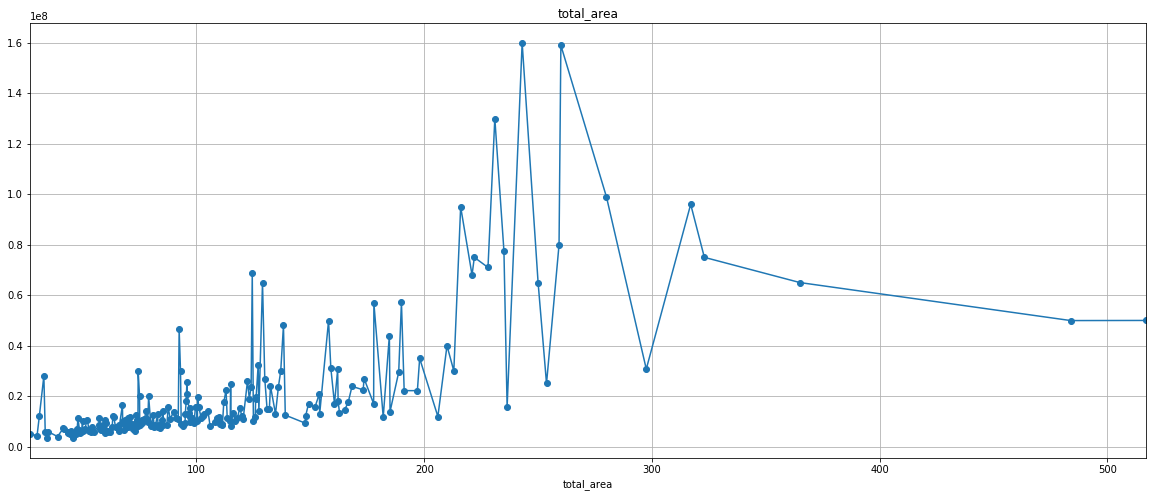

In [495]:
df_sankt_peterburg_center.groupby('total_area')['last_price'].mean().plot(style="o-",figsize=(20,8),title='total_area',grid=True)

<div class="alert alert-block alert-info" style="border-radius: 15px">
    
**3**

На всех крафиках удалил медиану, думаю после очистки от выбросов среднее точнее отражает картину

</div>

<div class="alert alert-block alert-info" style="border-radius: 15px">
    
**2**

Оценка зависимости цены жилья в центре Санкт-Петербурга от:

1. Площади. Слабая, прямая, нелинейная, имеет значительные колебания цены в районе 200 - 300 кв.м

</div>

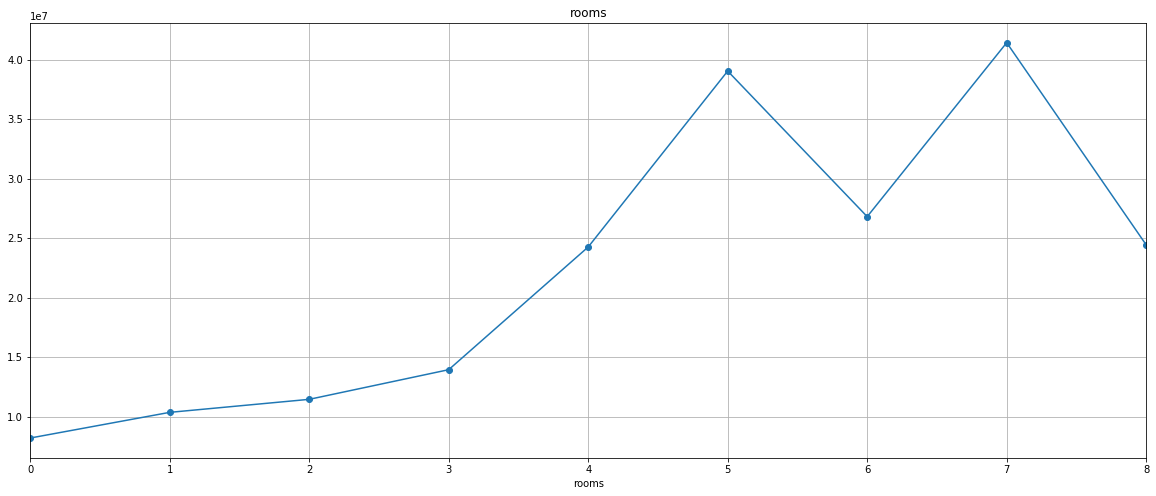

In [496]:
df_sankt_peterburg_center.groupby('rooms')['last_price'].mean().plot(style="o-",figsize=(20,8),title='rooms',grid=True)

<div class="alert alert-block alert-info" style="border-radius: 15px">
    
**2**

Оценка зависимости цены жилья в центре Санкт-Петербурга от:
    
2. Количества комнат. Слабая, прямая, нелинейная, рост после 4 ком. квартир. Среднее значение цены больше медианы - 
   распределение смещено вправо - "выскочки" по стоимости
        
</div>

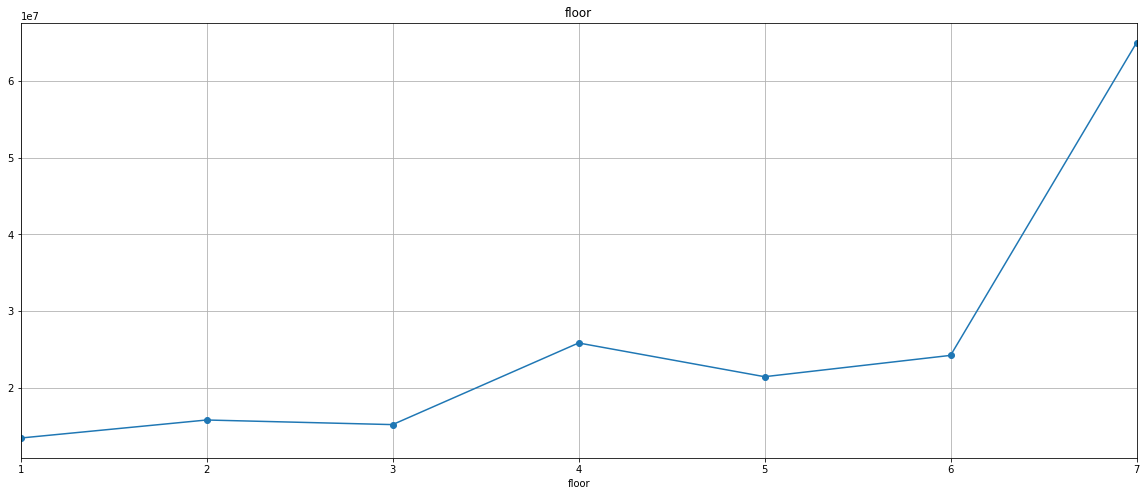

In [497]:
df_sankt_peterburg_center.groupby('floor')['last_price'].mean().plot(style="o-",figsize=(20,8),title='floor',grid=True)

<div class="alert alert-block alert-info" style="border-radius: 15px">
    
**2**

Оценка зависимости цены жилья в центре Санкт-Петербурга от:
    
3. Этажа. Очень низкая, 1й этаж - дешевле, максимальный этаж в центре 7 и ценится выше всего. Среднее значение цены 
   больше медианы - распределение смещено вправо - "выскочки" по стоимости
        
</div>

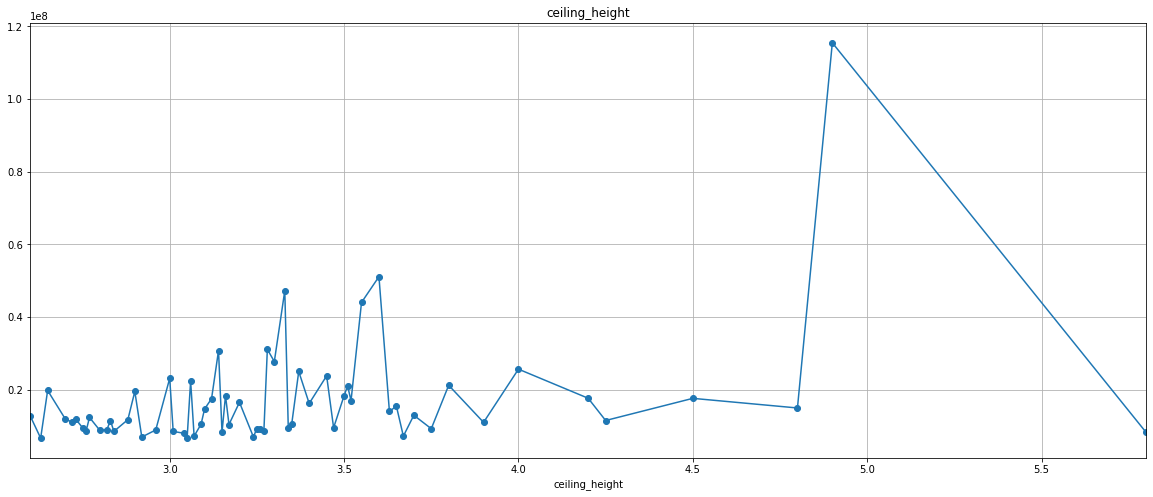

In [498]:
df_sankt_peterburg_center.groupby('ceiling_height')['last_price'].mean().plot(style="o-",figsize=(20,8),title='ceiling_height',grid=True)

<div class="alert alert-block alert-info" style="border-radius: 15px">
    
**2**

Оценка зависимости цены жилья в центре Санкт-Петербурга от:
   
4. Высоты потолков. Очень низкая, отмечается небольшой рост цены в районе 3,5 метров. 
        
</div>

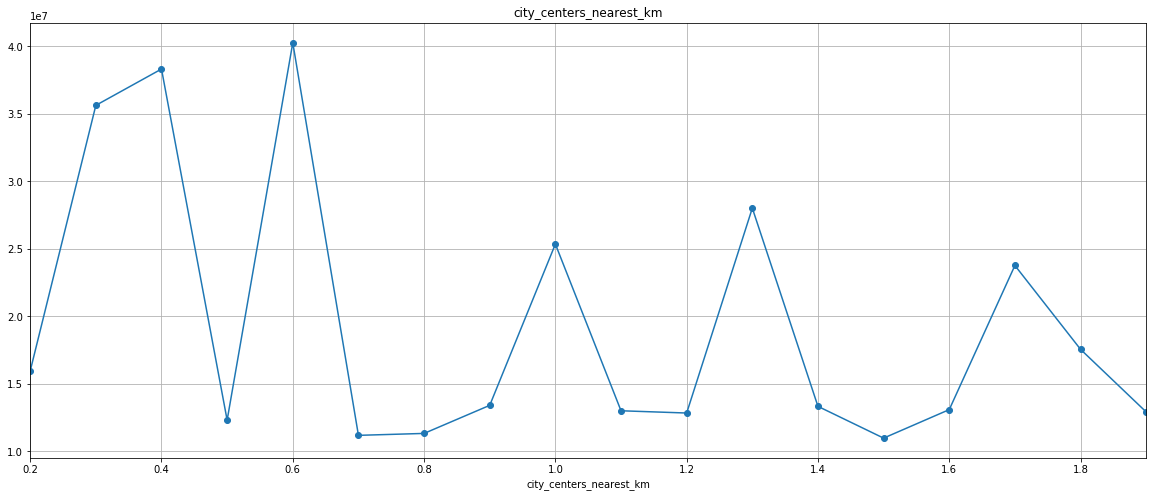

In [499]:
df_sankt_peterburg_center.groupby('city_centers_nearest_km')['last_price'].mean().plot(style="o-",figsize=(20,8),title='city_centers_nearest_km',grid=True)

<div class="alert alert-block alert-info" style="border-radius: 15px">
    
**2**

Оценка зависимости цены жилья в центре Санкт-Петербурга от:
    
5. Расстояния от центра города. В пределах 2х километров очень низкая, нелинейная, наблюдается тренд на уменьшение      стоимости. Резкие выпады по стоимости до 600 метров. Средние значения больше медианы - распределение смещено          вправо - "выскочки" по стоимости
        
</div>

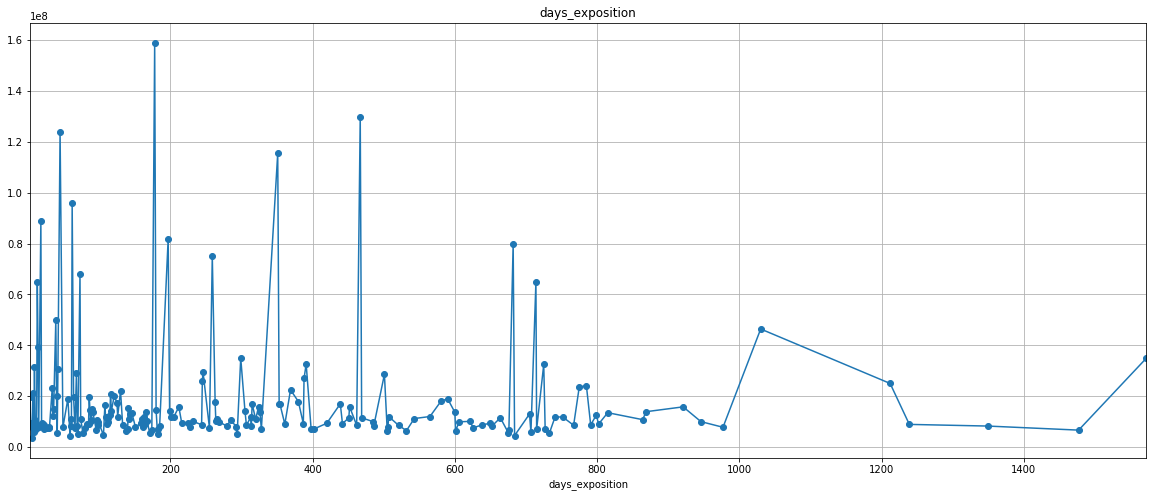

In [500]:
df_sankt_peterburg_center.groupby('days_exposition')['last_price'].mean().plot(style="o-",figsize=(20,8),title='days_exposition',grid=True)

<div class="alert alert-block alert-info" style="border-radius: 15px">
    
**2**

Оценка зависимости цены жилья в центре Санкт-Петербурга от:
    
6. Даты объявления. Зависимости нет. Скачки цен не указывают на какую-либо закономерность.
        
</div>

<div class="alert alert-block alert-info" style="border-radius: 15px">
    
**2**
    
Общий вывод по всем данным

Для проведения анализа из данных исключены варианты жилья очень низкой стоимостью, аномально высокой стоимостью 
в т. ч. за кв. метр, огромной или неестественно маленькой площадью и большим количеством комнат, 
а также варианты с недопустимо низкими или очень высокими потолками.
Наибольшим спросом пользуются типичные 1, 2, реже 3х комнатные квартиры с усредненными характеристиками: 
площадь 30-50 кв. м., стоимостью 3 – 6 млн. при стоимости кв. метра в районе 90 тыс.
Вариантов таких квартир большинство и продаются они в основном в период от 1,5 до 8 месяцев
Очень быстрая продажа до 1,5 месяцев происходит вероятно по причине очень выгодного предложения, 
и наоборот «долгий вариант» - продавец не хочет уступать, либо это жилье экстракласса
Из 10 населенных пунктов с максимальным количеством предложений Санкт-Петербург 
имеет самую высокую среднюю стоимость кв. метра, а Выборг - самую низкую

    
</div>

<div class="alert alert-block alert-info" style="border-radius: 15px">
    
**2**

Оценка зависимости цены жилья в центре Санкт-Петербурга от:

1. Площади. Слабая, прямая, нелинейная, имеет значительные колебания цены в районе 200 - 300 кв.м
    
2. Количества комнат. Слабая, прямая, нелинейная, рост после 4 ком. квартир. Среднее значение цены больше медианы - 
   распределение смещено вправо - "выскочки" по стоимости
    
3. Этажа. Очень низкая, 1й этаж - дешевле, максимальный этаж в центре 7 и ценится выше всего. Среднее значение цены 
   больше медианы - распределение смещено вправо - "выскочки" по стоимости
    
4. Высоты потолков. Очень низкая, отмечается небольшой рост цены в районе 3,5 метров. 
    
5. Расстояния от центра города. В пределах 2х километров очень низкая, нелинейная, наблюдается тренд на уменьшение      стоимости. Резкие выпады по стоимости до 600 метров. Средние значения больше медианы - распределение смещено          вправо - "выскочки" по стоимости
    
6. Даты объявления. Зависимости нет. Скачки цен не указывают на какую-либо закономерность.
        
</div>

<div class="alert alert-block alert-info" style="border-radius: 15px">
     
**3**
      
Отличия спроса на все варианты жилья от вариантов жилья в центре Санкт-Петербурга, наибольшим
  
спросом пользуются квартиры с характеристиками:

    все варианты --- в центре Санкт-Петербурга                                  
     
1, 2, реже 3х ком. квартиры --- 2, 3, реже 4х ком. квартиры    
       
площадь 30-50 кв. м. --- 50-100 кв. м.
        
стоимость 3 – 6 млн. --- 6 - 12 млн.
        
цена в районе 90 тыс./кв.м. --- 110 тыс./ кв.м.
        
продажа от 1,5 до 8 месяцев --- до 3х месяцев 
    
</div>

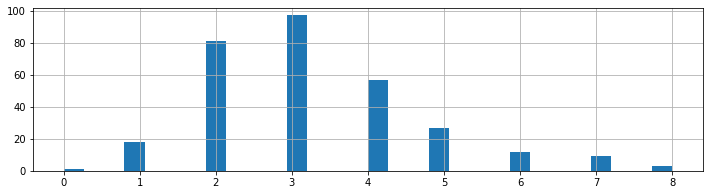

In [501]:
df_sankt_peterburg_center.rooms.hist(bins = 30, figsize = (12, 3))

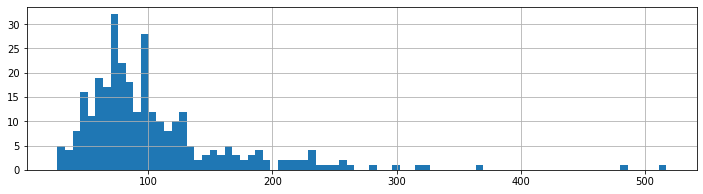

In [502]:
df_sankt_peterburg_center.total_area.hist(bins = 80, figsize = (12, 3))

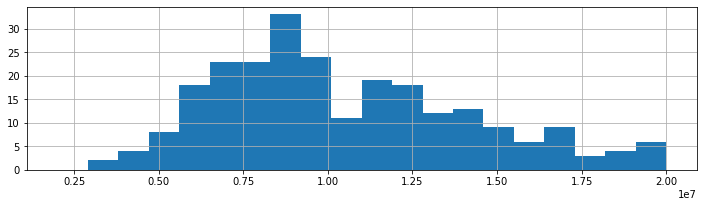

In [503]:
df_sankt_peterburg_center.last_price.hist(bins = 20, range = (2000000, 20000000), figsize = (12, 3))

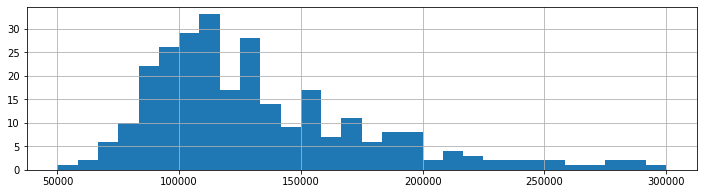

In [504]:
df_sankt_peterburg_center.price_meter.hist(bins = 30, range = (50000, 300000),figsize = (12, 3))

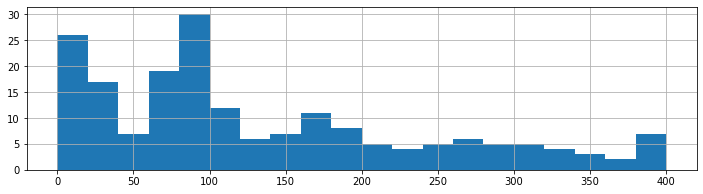

In [505]:
df_sankt_peterburg_center.days_exposition.hist(bins = 20, range = (0, 400), figsize = (12, 3))

<div class="alert alert-block alert-info" style="border-radius: 15px">
     
**3**
      
    Квартиры в центре Санкт-Петерурга являются более дорогим сегментом недвижимости в          сравнении с квартирами на окраине города или области.
    Более популярны квартиры с большим количеством комнат и большей площадью, стоимостью примерно в 2 раза выше и продаются квартиры в целом быстрее.
    
</div>